# Mapping Emotions Between Music and Lyrics

In this project we are explore the alignment of emotions between music and lyrics. 

To this end we are leveraging `MuLan embeddings`, a joint audio-language embedding model. By mapping music audio and natural language descriptions into a shared embedding space, MuLan enables us to capture semantic and emotional similarities across modalities. Our aim is to analyze and visualize the emotional alignment between music and lyrics.

# Initial Setup

Here we will setup basic dependencies for our project. Like enviorment file reading library loading etc 

In [ ]:
# from acrcloud.recognizer import ACRCloudRecognizer
import os
# from dotenv import load_dotenv
from Meta_Data_Collection import MetaDataCollection 
from Meta_Data_Collection_AudD import AudDMetaDataCollection
import pandas as pd
from Lyrics_Extraction import LyricsExtractor
import time 
from lyrics_preprocessing import process_lyrics_folder
from lyrics_audio_embeddings import process_all_embeddings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


# load_dotenv()

# Data Collection

For our data we are using a combination of the [DEAM dataset](https://cvml.unige.ch/databases/DEAM/) for audio and [LyricWiki](https://pypi.org/project/lyricwikia/) for the lyrics. 

- DEAM contains over 1,800 songs with annotations for dynamic and continuous emotion labels (valence and arousal) at the level of short segments. 

- While it does not contain raw audio data, LyricWiki and Musixmatch add lyric annotations for semantic and sentiment analysis.

## Getting Audio Meta-data

Altought DEAM contains the raw audio files with annotations, it however does not contain structured meta-data (Song Titel, Author, Year of release.. etc) for the 2014 entries(and since 2014 has the most number of entries) so we will get the metadata using some other apis which will be required to get the lyrics from lyric wiki.

- ACR Cloud is recognition services that can identify music based on audio fingerprints.

In [ ]:
## Let's first get the metadata and lyrics for the files with good metadata provided by DEAM

df_2013 = pd.read_csv("Data/metadata/metadata_2013.csv")
df_2015 = pd.read_csv("Data/metadata/metadata_2015.csv", on_bad_lines='skip')

df_2013 = df_2013.rename(columns={
    'song_id': 'song_id',
    'Artist': 'artist',
    'Song title': 'title',
    'Genre': 'genre'
})

# Standardize column names for 2015 dataset
df_2015 = df_2015.rename(columns={
    'id': 'song_id',
    'title': 'title',
    'artist': 'artist',
    'genre': 'genre'
})

df_2013 = df_2013[['song_id', 'artist', 'title', 'genre']]
df_2015 = df_2015[['song_id', 'artist', 'title', 'genre']]

df_2013['full song'] = False
df_2015['full song'] = True

combined_df = pd.concat([df_2013, df_2015], ignore_index=True)

for col in combined_df.select_dtypes(include=['object']):  # Select only text columns
    combined_df[col] = combined_df[col].str.strip('\t')


combined_df.to_csv('./Data/metadata/combined_metadata.csv', index=False)

print("Combined dataset saved as 'combined_songs.csv'")

## We already got the lyrics and combined them with lyrics from other metadata (Was done in other branch, lost some code here)

In [2]:
acr_host=os.getenv('HOST')
acr_access_key=os.getenv('ACCESS_KEY')
arc_secret=os.getenv('SECRET_KEY')

## Setup ACR Cloud for music recognition and get all the metadata

config = {
    "host": acr_host, 
    "access_key": acr_access_key,
    "access_secret": arc_secret,
    "timeout": 10 #seconds
}

recognizer = ACRCloudRecognizer(config)
metadata_collector = MetaDataCollection(recognizer)

audio_directory = "Data/MEMD_audio"
output_csv = "song_metadata.csv"

metadata_collector.process_audio_files(audio_directory, output_csv)

Processing: Data/MEMD_audio/10.mp3
Processing: Data/MEMD_audio/1000.mp3
Processing: Data/MEMD_audio/1001.mp3
Processing: Data/MEMD_audio/1002.mp3
Processing: Data/MEMD_audio/1003.mp3
Processing: Data/MEMD_audio/1004.mp3
Processing: Data/MEMD_audio/1005.mp3
Processing: Data/MEMD_audio/1006.mp3
Processing: Data/MEMD_audio/1007.mp3
Processing: Data/MEMD_audio/1008.mp3
Processing: Data/MEMD_audio/1009.mp3
Processing: Data/MEMD_audio/101.mp3
Processing: Data/MEMD_audio/1010.mp3
Processing: Data/MEMD_audio/1011.mp3
Processing: Data/MEMD_audio/1012.mp3
Processing: Data/MEMD_audio/1013.mp3
Processing: Data/MEMD_audio/1014.mp3
Processing: Data/MEMD_audio/1015.mp3
Processing: Data/MEMD_audio/1016.mp3
Processing: Data/MEMD_audio/1017.mp3
Processing: Data/MEMD_audio/1018.mp3
Processing: Data/MEMD_audio/1019.mp3
Processing: Data/MEMD_audio/102.mp3
Processing: Data/MEMD_audio/1020.mp3
Processing: Data/MEMD_audio/1021.mp3
Processing: Data/MEMD_audio/1022.mp3
Processing: Data/MEMD_audio/1023.mp3
Proce

### Trying with different sources

Since we only got the metadata for around 800 files, let's try different sources 

We will use AudD, but since it has a Api limit of 300 per month, let's do it in batches

In [9]:
songs = pd.read_csv("Data/Useable_data/song_metadata.csv")
songs.replace("Not Found", pd.NA, inplace=True)
songs_with_no_metadata = songs[songs['artist'].isna() & songs['title'].isna()]

In [ ]:
aud_api_token = os.getenv("AUDD_API_TOKEN")

data = {
    'api_token': aud_api_token,
    'return': 'apple_music,spotify',
}
    
aud_collector = AudDMetaDataCollection(data, songs_with_no_metadata[901:])

aud_collector.process_audio_files("./Data/Useable_data/Other_Songs_Metadata.csv")

In [10]:
meta_data_from_aud = pd.read_csv("./Data/Useable_data/Other_Songs_Metadata.csv")

prev_songs = songs.copy()
songs.update(meta_data_from_aud)

total_len = len(songs)
print(f"Current Meta_data length: {total_len - len(songs[songs['artist'].isna() & songs['title'].isna()])}\nPrev Meta_data length: {total_len - len(prev_songs[prev_songs['artist'].isna() & prev_songs['title'].isna()])}")

Current Meta_data length: 925
Prev Meta_data length: 816


In [11]:
songs.to_csv("./Data/Useable_data/song_metadata_updated.csv")

## Getting lyrics

Now that we have the metadata, let's load it and take a look. 

We don't have the meta-data for all the files, but let's work with what we have, and try to get the lyrics from it. 

In [2]:
## Read the metadata from the CSV file

metadata_df = pd.read_csv("Data/Useable_data/song_metadata_updated.csv")
metadata_df.replace("Not Found", pd.NA, inplace=True)
metadata_df.head()

,Unnamed: 0,audio_file,artist,title,genres,release_date,label
0,0,1002.mp3,Shun & Hoshina Anniversary,Dirty Shoes,<NA>,2012-07-18,Den Haku Records
1,1,1011.mp3,BERNARD MARQUIÉ,Wayne's Reflexions,<NA>,2022-12-28,BERNARD MARQUIÉ
2,2,1045.mp3,MarmutzZ,Semangat (Acoustic),<NA>,2023-12-09,MarmutzZ
3,3,1071.mp3,Subin Kumar,Mayur Nache,<NA>,2023-10-20,BS Music Entertainment
4,4,1074.mp3,Alan Clouds,Game,<NA>,2015-01-20,Alan Clouds


Let's drop the rows where all the rows are empty.

In [3]:
non_empty_metadata_df = metadata_df.dropna(how='all', subset=["artist", "title", "genres", "release_date", "label"])
non_empty_metadata_df.head()

,Unnamed: 0,audio_file,artist,title,genres,release_date,label
0,0,1002.mp3,Shun & Hoshina Anniversary,Dirty Shoes,<NA>,2012-07-18,Den Haku Records
1,1,1011.mp3,BERNARD MARQUIÉ,Wayne's Reflexions,<NA>,2022-12-28,BERNARD MARQUIÉ
2,2,1045.mp3,MarmutzZ,Semangat (Acoustic),<NA>,2023-12-09,MarmutzZ
3,3,1071.mp3,Subin Kumar,Mayur Nache,<NA>,2023-10-20,BS Music Entertainment
4,4,1074.mp3,Alan Clouds,Game,<NA>,2015-01-20,Alan Clouds


Now let's get on with the lyrics.

In [4]:
GENIUS_API_TOKEN = os.getenv("GENIUS_API_TOKEN")
extractor = LyricsExtractor(GENIUS_API_TOKEN)

non_empty_metadata_df['lyrics'] = pd.NA

for idx, row in non_empty_metadata_df.iterrows():
    artist = row['label'] if pd.isna(row['artist']) else row['artist']
    print(f"Fetching lyrics for: {row['title']} by {artist}")
    lyrics = extractor.fetch_lyrics(row["title"], artist)
    non_empty_metadata_df.at[idx, "lyrics"] = lyrics
    time.sleep(1)

/tmp/ipykernel_6084/1114417751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_metadata_df['lyrics'] = pd.NA


Fetching lyrics for: Dirty Shoes by Shun & Hoshina Anniversary
Lyrics not found for 'Dirty Shoes' by 'Shun & Hoshina Anniversary'.
Fetching lyrics for: Wayne's Reflexions by BERNARD MARQUIÉ
Lyrics not found for 'Wayne's Reflexions' by 'BERNARD MARQUIÉ'.
Fetching lyrics for: Semangat (Acoustic) by MarmutzZ
Lyrics not found for 'Semangat (Acoustic)' by 'MarmutzZ'.
Fetching lyrics for: Mayur Nache by Subin Kumar
Lyrics not found for 'Mayur Nache' by 'Subin Kumar'.
Fetching lyrics for: Game by Alan Clouds
Lyrics not found for 'Game' by 'Alan Clouds'.
Fetching lyrics for: Neapolitana by ZveroboyZ
Lyrics not found for 'Neapolitana' by 'ZveroboyZ'.
Fetching lyrics for: Wait for U by araa mikey
Lyrics not found for 'Wait for U' by 'araa mikey'.
Fetching lyrics for: Crying by Christian Hovda
Lyrics not found for 'Crying' by 'Christian Hovda'.
Fetching lyrics for: Capítulo 1.15 - los Cuervos del Vaticano - No Dramatizado by Eric Frattini
Lyrics not found for 'Capítulo 1.15 - los Cuervos del Vati

In [36]:
lyrics_df = non_empty_metadata_df[pd.isna(non_empty_metadata_df['lyrics']) == False]
lyrics_df = lyrics_df.drop(columns=['Unnamed: 0'])
print(f"Songs with lyrics avaliable: {len(lyrics_df)}")

Songs with lyrics avaliable: 126


In [38]:
## Let's save the lyrics in seperate files with names from auido_file so we can get then
## Then save the new lyrics_df (But removing the lyrics col) in a seperate csv for better retreval

## Ensure lyrics_df is a copy, not a view
lyrics_df = lyrics_df.copy()

for idx, row in lyrics_df.iterrows():
    audio_file = row['audio_file'].split(".")[0]
    lyrics = row['lyrics']
    
    with open(f"Data/Useable_data/lyrics/{audio_file}.txt", "w") as f:
        f.write(lyrics)
    
# Drop the 'lyrics'
lyrics_df = lyrics_df.drop('lyrics', axis=1)

# Reset the index
lyrics_df.reset_index(drop=True, inplace=True)

lyrics_df.to_csv("Data/Useable_data/songs_with_lyrics.csv", mode='a', header=None, index=False)

In [6]:
lyrics_df = pd.read_csv("./Data/Useable_data/songs_with_lyrics.csv")
lyrics_df.drop_duplicates(subset=['audio_file'], inplace=True)
lyrics_df.drop(columns=['label', 'release_date'], inplace=True)
lyrics_df.to_csv("./Data/Useable_data/songs_with_lyrics_updated.csv", index=False)

We got around `150 songs with lyrics`, there are some other songs we might be able to use:

- Instrumental songs, songs with no lyrics
- Re-try with other lyrics api
- Use shazam for manual metadata collection for some songs

# Data Preprocessing

We will need to preform 2 types of data pre-processing 

- **For Audio**: 
    - Convert audio files to mono and resample to 16kHz if needed for MuLan compatibility.
    - Segment the audio into clips

- **For Text**: 
    - Remove special characters, stop words, and tokenize the lyrics.
    - Store the processed text for embedding extraction.


## Embeddings

Since we can't get the MuLan Embeddings directly we will use [Musiclm_pytorch](https://github.com/lucidrains/musiclm-pytorch) an open source library 

In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
input_folder = "./Data/Useable_data/lyrics"
output_folder = "./Data/Useable_data/lyrics_cleaned"

process_lyrics_folder(input_folder, output_folder)  

print(f"Lyrics processed and saved to {output_folder}")

Lyrics processed and saved to ./Data/Useable_data/lyrics_cleaned


In [2]:
lyrics_folder = './Data/Useable_data/lyrics_cleaned'
audio_folder = './Data/MEMD_audio'
lyrics_output = './Data/Embeddings/lyrics_embeddings.npy'
audio_output = './Data/Embeddings/audio_embeddings.npy'

# Process embeddings
process_all_embeddings(lyrics_folder, audio_folder, lyrics_output, audio_output)

Processing lyrics...
Lyrics embeddings saved to ./Data/Embeddings/lyrics_embeddings.npy
Processing audio...
Found 148 audio files. Processing in batches of 50...
Processing batch 1 with 50 files...
spectrogram yielded shape of (513, 1407), but had to be cropped to (512, 1392) to be patchified for transformer
Processed: 1211.mp3
Processed: 1239.mp3
Processed: 1985.mp3
Processed: 1615.mp3
Processed: 632.mp3
Processed: 96.mp3
Processed: 1403.mp3
Processed: 55.mp3
Processed: 1358.mp3
Processed: 1614.mp3
Processed: 1984.mp3
Processed: 974.mp3
Processed: 1210.mp3
Processed: 1212.mp3
Processed: 1206.mp3
Processed: 1986.mp3
Processed: 355.mp3
Processed: 1616.mp3
Processed: 95.mp3
Processed: 56.mp3
Processed: 591.mp3
Processed: 1213.mp3
Processed: 967.mp3
Processed: 1217.mp3
Processed: 1954.mp3
Processed: 1968.mp3
Processed: 581.mp3
Processed: 1767.mp3
Processed: 393.mp3
Processed: 1439.mp3
Processed: 1612.mp3
Processed: 1564.mp3
Processed: 1216.mp3
Processed: 1558.mp3
Processed: 1599.mp3
Proce

: 

# Testing

Original data:
Lyrics: 148 songs, shape: (148, 512)
Audio: 50 songs, shape: (50, 512)

After alignment:
Number of matching songs: 50
Final embedding shapes - Lyrics: (50, 512), Audio: (50, 512)


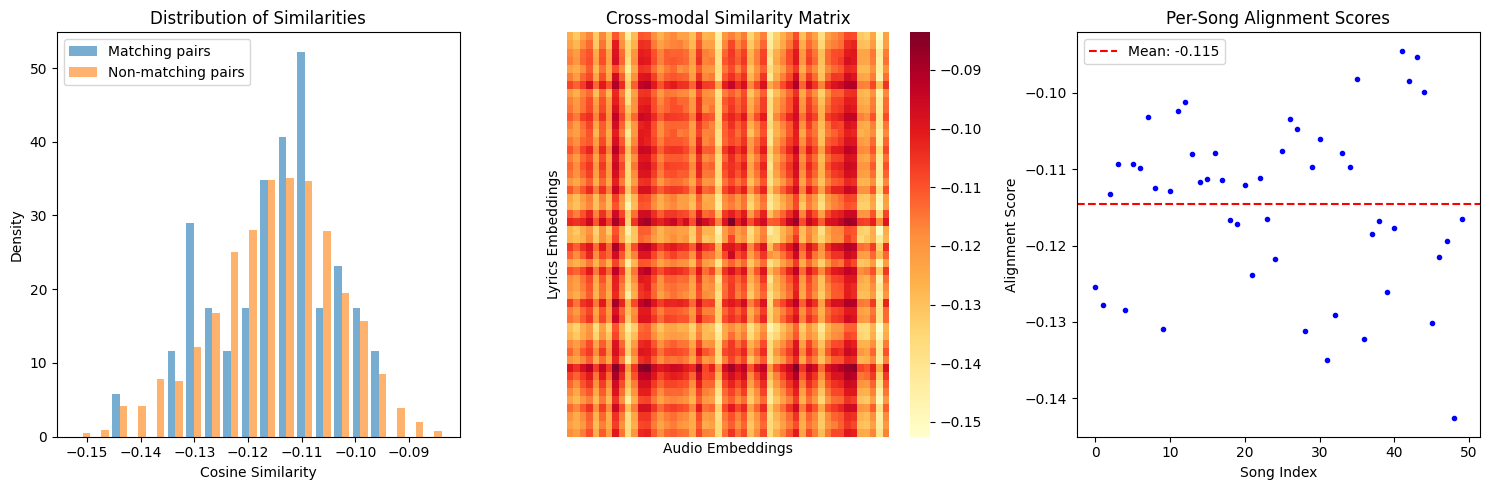


Alignment Statistics:
Number of songs analyzed: 50

Matching pairs similarity: -0.115 ± 0.011
Non-matching pairs similarity: -0.115 ± 0.012

Alignment effectiveness (σ above random): 0.04

Best matching song ID: 581 (similarity: -0.094)
Worst matching song ID: 967 (similarity: -0.143)


In [ ]:
class EmbeddingAnalyzer:
    def __init__(self, lyrics_embeddings_path, audio_embeddings_path):
        """Load embeddings from numpy NPZ files and align the data"""
        # Load embeddings
        lyrics_data = np.load(lyrics_embeddings_path, allow_pickle=True)
        audio_data = np.load(audio_embeddings_path, allow_pickle=True)
        
        # Extract song IDs and embeddings
        self.lyrics_song_ids = lyrics_data['song_ids']
        self.audio_song_ids = audio_data['song_ids']
        
        # Get raw embeddings and reshape if needed
        lyrics_emb = lyrics_data['embeddings']
        audio_emb = audio_data['embeddings']
        
        # Remove singleton dimensions if present
        self.lyrics_embeddings = np.squeeze(lyrics_emb)
        self.audio_embeddings = np.squeeze(audio_emb)
        
        print("Original data:")
        print(f"Lyrics: {len(self.lyrics_song_ids)} songs, shape: {self.lyrics_embeddings.shape}")
        print(f"Audio: {len(self.audio_song_ids)} songs, shape: {self.audio_embeddings.shape}")
        
        # Align the embeddings based on song IDs
        self._align_embeddings()
        
    def _align_embeddings(self):
        """Align embeddings to ensure we only compare matching songs"""
        # Find common song IDs
        common_ids = np.intersect1d(self.lyrics_song_ids, self.audio_song_ids)
        
        if len(common_ids) == 0:
            raise ValueError("No matching songs found between lyrics and audio embeddings!")
        
        # Get indices for common songs in both arrays
        lyrics_indices = [np.where(self.lyrics_song_ids == id)[0][0] for id in common_ids]
        audio_indices = [np.where(self.audio_song_ids == id)[0][0] for id in common_ids]
        
        # Filter embeddings to keep only matching songs
        self.lyrics_embeddings = self.lyrics_embeddings[lyrics_indices]
        self.audio_embeddings = self.audio_embeddings[audio_indices]
        self.song_ids = common_ids
        
        print(f"\nAfter alignment:")
        print(f"Number of matching songs: {len(common_ids)}")
        print(f"Final embedding shapes - Lyrics: {self.lyrics_embeddings.shape}, Audio: {self.audio_embeddings.shape}")

    def analyze_alignment(self):
        """Analyze alignment between modalities"""
        # Compute similarity matrix
        similarity_matrix = cosine_similarity(self.lyrics_embeddings, self.audio_embeddings)
        
        # Get matching pairs (diagonal) similarities
        matching_similarities = np.diag(similarity_matrix)
        
        # Get non-matching pairs similarities
        mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
        non_matching_similarities = similarity_matrix[mask]
        
        # Calculate statistics
        stats = {
            'avg_matching_sim': np.mean(matching_similarities),
            'std_matching_sim': np.std(matching_similarities),
            'avg_nonmatching_sim': np.mean(non_matching_similarities),
            'std_nonmatching_sim': np.std(non_matching_similarities),
            'best_match_idx': np.argmax(matching_similarities),
            'worst_match_idx': np.argmin(matching_similarities)
        }
        
        return similarity_matrix, stats
    
    def visualize_alignment(self):
        """Create visualization plots"""
        similarity_matrix, stats = self.analyze_alignment()
        
        plt.figure(figsize=(15, 5))
        
        # 1. Similarity Distribution
        plt.subplot(1, 3, 1)
        matching_sims = np.diag(similarity_matrix)
        mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
        nonmatching_sims = similarity_matrix[mask]
        
        plt.hist([matching_sims, nonmatching_sims], 
                label=['Matching pairs', 'Non-matching pairs'],
                bins=20, alpha=0.6, density=True)
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Density')
        plt.title('Distribution of Similarities')
        plt.legend()
        
        # 2. Similarity Matrix Heatmap
        plt.subplot(1, 3, 2)
        sns.heatmap(similarity_matrix, 
                   cmap='YlOrRd',
                   xticklabels=False, 
                   yticklabels=False)
        plt.title('Cross-modal Similarity Matrix')
        plt.xlabel('Audio Embeddings')
        plt.ylabel('Lyrics Embeddings')
        
        # 3. Alignment Scores
        plt.subplot(1, 3, 3)
        plt.plot(matching_sims, 'b.')
        plt.axhline(y=stats['avg_matching_sim'], 
                   color='r', 
                   linestyle='--', 
                   label=f'Mean: {stats["avg_matching_sim"]:.3f}')
        plt.xlabel('Song Index')
        plt.ylabel('Alignment Score')
        plt.title('Per-Song Alignment Scores')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nAlignment Statistics:")
        print(f"Number of songs analyzed: {len(self.song_ids)}")
        print(f"\nMatching pairs similarity: {stats['avg_matching_sim']:.3f} ± {stats['std_matching_sim']:.3f}")
        print(f"Non-matching pairs similarity: {stats['avg_nonmatching_sim']:.3f} ± {stats['std_nonmatching_sim']:.3f}")
        
        # Calculate effectiveness
        effectiveness = (stats['avg_matching_sim'] - stats['avg_nonmatching_sim']) / stats['std_nonmatching_sim']
        print(f"\nAlignment effectiveness (σ above random): {effectiveness:.2f}")
        
        # Print best and worst matching songs
        print(f"\nBest matching song ID: {self.song_ids[stats['best_match_idx']]} (similarity: {matching_sims[stats['best_match_idx']]:.3f})")
        print(f"Worst matching song ID: {self.song_ids[stats['worst_match_idx']]} (similarity: {matching_sims[stats['worst_match_idx']]:.3f})")


analyzer = EmbeddingAnalyzer(
    lyrics_embeddings_path='./Data/Embeddings/lyrics_embeddings.npy.npz',
    audio_embeddings_path='./Data/Embeddings/audio_embeddings.npy_batch_1.npz'
)

analyzer.visualize_alignment()

Loading and preparing data...

Data loaded successfully:
Number of songs: 50
Embedding dimensions - Lyrics: (50, 512), Audio: (50, 512)


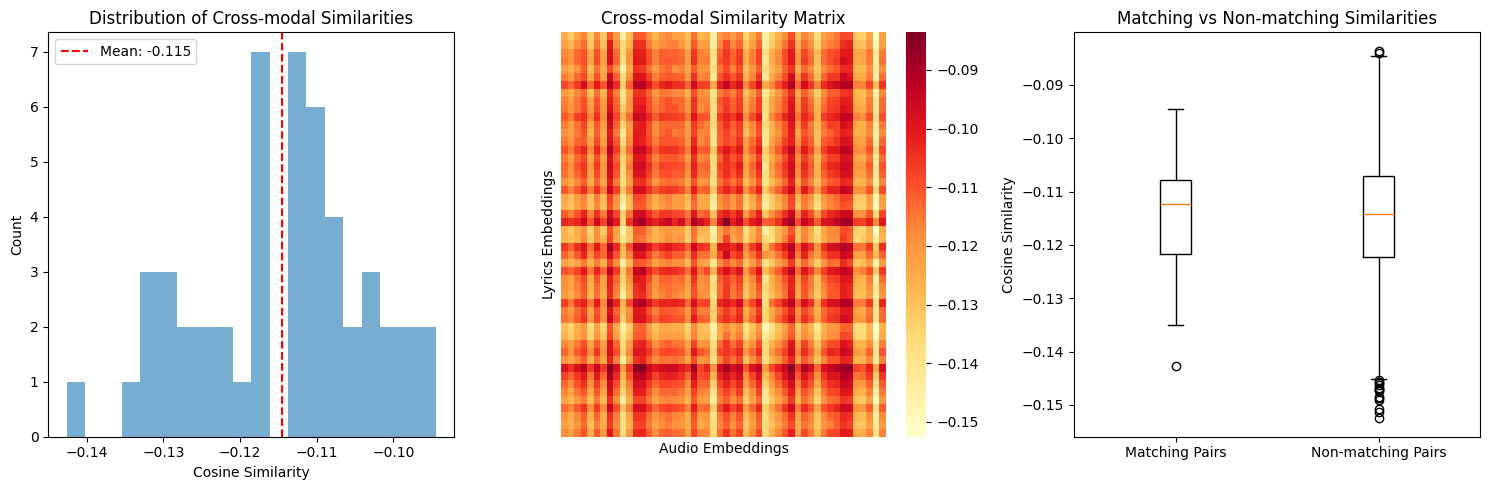


Cross-modal Analysis Results:

Matching Pairs Statistics:
mean: -0.115
std: 0.011
min: -0.143
max: -0.094

Non-matching Pairs Statistics:
mean: -0.115
std: 0.012
min: -0.153
max: -0.084

Effectiveness (σ above random): 0.039

Results have been saved to mulan_emotional_analysis_results.txt


In [ ]:
class MuLanEmotionalAnalyzer:
    def __init__(self):
        """Initialize the analyzer with emotion categories"""
        # Define emotion categories based on common music emotion taxonomy
        self.emotion_categories = {
            'joy': ['happy', 'cheerful', 'excited', 'energetic'],
            'sadness': ['sad', 'melancholic', 'depressed', 'gloomy'],
            'anger': ['angry', 'aggressive', 'intense', 'fierce'],
            'tenderness': ['tender', 'soft', 'gentle', 'romantic'],
            'fear': ['scary', 'tense', 'anxious', 'nervous'],
            'surprise': ['surprised', 'amazed', 'astonished', 'unexpected']
        }
    
    def analyze_embeddings(self, lyrics_embeddings, audio_embeddings, song_ids):
        """
        Analyze emotions using pre-computed MuLan embeddings
        
        Args:
            lyrics_embeddings: numpy array of shape (n_songs, embedding_dim)
            audio_embeddings: numpy array of shape (n_songs, embedding_dim)
            song_ids: list of song identifiers
        """
        results = {
            'per_song': [],
            'aggregate': {},
            'cross_modal': self._analyze_cross_modal(lyrics_embeddings, audio_embeddings)
        }
        
        # Analyze each song
        for i, song_id in enumerate(song_ids):
            song_result = {
                'song_id': song_id,
                'lyrics_embedding': lyrics_embeddings[i],
                'audio_embedding': audio_embeddings[i],
                'similarity': cosine_similarity(
                    lyrics_embeddings[i].reshape(1, -1), 
                    audio_embeddings[i].reshape(1, -1)
                )[0][0]
            }
            results['per_song'].append(song_result)
        
        # Calculate aggregate statistics
        results['aggregate'] = self._calculate_aggregate_stats(results['per_song'])
        
        return results
    
    def _analyze_cross_modal(self, lyrics_embeddings, audio_embeddings):
        """Analyze cross-modal relationships in the embeddings"""
        # Calculate full similarity matrix
        similarity_matrix = cosine_similarity(lyrics_embeddings, audio_embeddings)
        
        # Get diagonal (matching pairs) and off-diagonal (non-matching pairs) similarities
        matching_similarities = np.diag(similarity_matrix)
        mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
        non_matching_similarities = similarity_matrix[mask]
        
        return {
            'similarity_matrix': similarity_matrix,
            'matching_stats': {
                'mean': np.mean(matching_similarities),
                'std': np.std(matching_similarities),
                'min': np.min(matching_similarities),
                'max': np.max(matching_similarities)
            },
            'non_matching_stats': {
                'mean': np.mean(non_matching_similarities),
                'std': np.std(non_matching_similarities),
                'min': np.min(non_matching_similarities),
                'max': np.max(non_matching_similarities)
            },
            'effectiveness': (np.mean(matching_similarities) - np.mean(non_matching_similarities)) / 
                           np.std(non_matching_similarities)
        }
    
    def _calculate_aggregate_stats(self, per_song_results):
        """Calculate aggregate statistics across all songs"""
        similarities = [song['similarity'] for song in per_song_results]
        
        return {
            'similarity_stats': {
                'mean': np.mean(similarities),
                'std': np.std(similarities),
                'min': np.min(similarities),
                'max': np.max(similarities)
            }
        }
    
    def visualize_results(self, results):
        """Create visualizations of the analysis results"""
        plt.figure(figsize=(15, 5))
        
        # 1. Similarity Distribution
        plt.subplot(131)
        similarities = [song['similarity'] for song in results['per_song']]
        plt.hist(similarities, bins=20, alpha=0.6)
        plt.axvline(results['aggregate']['similarity_stats']['mean'], 
                   color='r', linestyle='--', 
                   label=f"Mean: {results['aggregate']['similarity_stats']['mean']:.3f}")
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Count')
        plt.title('Distribution of Cross-modal Similarities')
        plt.legend()
        
        # 2. Cross-modal Similarity Matrix
        plt.subplot(132)
        sns.heatmap(results['cross_modal']['similarity_matrix'], 
                   cmap='YlOrRd',
                   xticklabels=False, 
                   yticklabels=False)
        plt.title('Cross-modal Similarity Matrix')
        plt.xlabel('Audio Embeddings')
        plt.ylabel('Lyrics Embeddings')
        
        # 3. Matching vs Non-matching Similarities
        plt.subplot(133)
        plt.boxplot([
            np.diag(results['cross_modal']['similarity_matrix']),
            results['cross_modal']['similarity_matrix'][~np.eye(
                results['cross_modal']['similarity_matrix'].shape[0], dtype=bool
            )]
        ], labels=['Matching Pairs', 'Non-matching Pairs'])
        plt.title('Matching vs Non-matching Similarities')
        plt.ylabel('Cosine Similarity')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nCross-modal Analysis Results:")
        print("\nMatching Pairs Statistics:")
        for key, value in results['cross_modal']['matching_stats'].items():
            print(f"{key}: {value:.3f}")
        
        print("\nNon-matching Pairs Statistics:")
        for key, value in results['cross_modal']['non_matching_stats'].items():
            print(f"{key}: {value:.3f}")
        
        print(f"\nEffectiveness (σ above random): {results['cross_modal']['effectiveness']:.3f}")

def load_and_prepare_data(lyrics_path, audio_path):
    """Load and prepare the MuLan embeddings"""
    # Load the NPZ files
    lyrics_data = np.load(lyrics_path, allow_pickle=True)
    audio_data = np.load(audio_path, allow_pickle=True)
    
    # Extract song IDs and embeddings
    lyrics_song_ids = lyrics_data['song_ids']
    audio_song_ids = audio_data['song_ids']
    
    # Get embeddings and remove singleton dimensions
    lyrics_emb = np.squeeze(lyrics_data['embeddings'])
    audio_emb = np.squeeze(audio_data['embeddings'])
    
    # Find common songs
    common_ids = np.intersect1d(lyrics_song_ids, audio_song_ids)
    
    # Get indices for common songs
    lyrics_indices = [np.where(lyrics_song_ids == id)[0][0] for id in common_ids]
    audio_indices = [np.where(audio_song_ids == id)[0][0] for id in common_ids]
    
    # Filter embeddings to keep only matching songs
    aligned_lyrics = lyrics_emb[lyrics_indices]
    aligned_audio = audio_emb[audio_indices]
    
    return aligned_lyrics, aligned_audio, common_ids


lyrics_path = './Data/Embeddings/lyrics_embeddings.npy.npz'
audio_path = './Data/Embeddings/audio_embeddings.npy_batch_1.npz'


# Load and prepare data
print("Loading and preparing data...")
lyrics_embeddings, audio_embeddings, song_ids = load_and_prepare_data(
    lyrics_path,
    audio_path
)

print(f"\nData loaded successfully:")
print(f"Number of songs: {len(song_ids)}")
print(f"Embedding dimensions - Lyrics: {lyrics_embeddings.shape}, Audio: {audio_embeddings.shape}")

# Create analyzer and run analysis
analyzer = MuLanEmotionalAnalyzer()
results = analyzer.analyze_embeddings(lyrics_embeddings, audio_embeddings, song_ids)

# Visualize results
analyzer.visualize_results(results)

output_file = "mulan_emotional_analysis_results.txt"
with open(output_file, "w") as f:
    f.write("=== MuLan Emotional Analysis Results ===\n\n")
    
    # Write cross-modal statistics
    f.write("Cross-modal Analysis:\n")
    f.write(f"Effectiveness (σ above random): {results['cross_modal']['effectiveness']:.3f}\n\n")
    
    f.write("Matching Pairs Statistics:\n")
    for key, value in results['cross_modal']['matching_stats'].items():
        f.write(f"{key}: {value:.3f}\n")
    
    f.write("\nNon-matching Pairs Statistics:\n")
    for key, value in results['cross_modal']['non_matching_stats'].items():
        f.write(f"{key}: {value:.3f}\n")
    
    # Write per-song results
    f.write("\nPer-song Results:\n")
    for song_result in results['per_song']:
        f.write(f"\nSong {song_result['song_id']}:\n")
        f.write(f"Cross-modal similarity: {song_result['similarity']:.3f}\n")

print(f"\nResults have been saved to {output_file}")
